# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_ForecastingTrader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pickle
import time
import sys
import json
import os

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

# Import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Dropout
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ProgbarLogger

In [3]:
config_file = 'config/config_commodities_2010_2019.json'

In [4]:
pd.__version__

'0.24.2'

### Import Configurations

In [5]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [6]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [7]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [8]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')

# inter day
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

In [9]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values


In [10]:
len(df_prices_train)+len(df_prices_test)

195414

# Load Pairs

In [11]:
# intra day
#with open('data/etfs/pickle/pairs_unfiltered_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_category_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

with open('data/etfs/pickle/pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
    
# interday  
#with open('data/etfs/pickle/pairs_unfiltered_interday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_category_interday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_unsupervised_learning_interday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

In [12]:
# intraday
n_years_train = round(len(df_prices_train)/(240*78))

# interday
#n_years_train = round(len(df_prices_train)/(240))

n_years_train

9

# The ideal scenario - forecasting accuracy of 100%

In [32]:
# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date
cumret_pairs = []    
summaries = []
for i in range(len(pairs)):
    example = pairs[i]
    example_spread = example[2]['spread']

    # normalize data
    standardization_dict = {'mean':example_spread[:train_val_split].mean(),
                            'std':np.std(example_spread[:train_val_split])}
    example_spread_norm = (example_spread - standardization_dict['mean'])/standardization_dict['std']
    example_spread_destandardized = forecasting_trader.destandardize(example_spread_norm,
                                                                     standardization_dict['mean'],
                                                                     standardization_dict['std'])
    print(len(example_spread[example_spread != example_spread_destandardized]))
    
    # spread validation
    spread_val = example_spread[train_val_split:]
    #predictions = example_spread[train_val_split:]
    predictions = forecasting_trader.destandardize(example_spread_norm[train_val_split:],
                                                   standardization_dict['mean'],
                                                   standardization_dict['std'])

    ret_example, cumret_example, summary_example = forecasting_trader.forecast_spread_trading(
                                                                       X=example[2]['X_train'][train_val_split:],
                                                                       Y=example[2]['Y_train'][train_val_split:],
                                                                       spread_test=spread_val,
                                                                       spread_train=example_spread[:train_val_split],
                                                                       beta=pairs[i][2]['coint_coef'], 
                                                                       predictions=predictions,
                                                                       lag=1,
                                                                       low_quantile=0.05,
                                                                       high_quantile=0.95)
    print('Pair {}: Accumulated return: {}%'.format(i,cumret_example[-1]*100))
    cumret_pairs.append(cumret_example[-1]*100)
    summaries.append(summary_example)
    #cumret_example.plot()
print('\nAverage annual ROI: {:.2f}'.format(np.mean(cumret_pairs)))

27671
Long threshold: 50.00
Short threshold: -50.00
Pair 0: Accumulated return: 6.35057233484746%
17304
Long threshold: 13.62
Short threshold: -13.75
Pair 1: Accumulated return: 21.66706687384736%
3633
Long threshold: 9.43
Short threshold: -8.74
Pair 2: Accumulated return: 23.15564234617089%
8818
Long threshold: 12.01
Short threshold: -11.86
Pair 3: Accumulated return: 30.960214189612635%
8411
Long threshold: 50.00
Short threshold: -50.00
Pair 4: Accumulated return: 24.31988366940534%
4856
Long threshold: 13.44
Short threshold: -15.06
Pair 5: Accumulated return: 44.54496356617603%

Average annual ROI: 25.17


In [25]:
print(summaries[0][summaries[0].trading_days !=0]['predicted_change(%)'].abs().mean())
print(summaries[1][summaries[1].trading_days !=0]['predicted_change(%)'].abs().mean())
print(summaries[2][summaries[2].trading_days !=0]['predicted_change(%)'].abs().mean())
print(summaries[3][summaries[3].trading_days !=0]['predicted_change(%)'].abs().mean())

169.02780870329383
19.231942582127974
16.474765883169642
17.94623904071214


In [46]:
example = pairs[0]
example_spread = example[2]['spread']

# normalize data
standardization_dict = {'mean':example_spread[:train_val_split].mean(),
                        'std':np.std(example_spread[:train_val_split])}
example_spread_norm = (example_spread - standardization_dict['mean'])/standardization_dict['std']
example_spread_destandardized = forecasting_trader.destandardize(example_spread_norm,
                                                                     standardization_dict['mean'],
                                                                     standardization_dict['std'])

difference=example_spread-example_spread_destandardized
lendifference[difference!=0]

 1.110223e-16    7211
-2.220446e-16    5319
-1.110223e-16    3875
-1.387779e-17    3361
 2.220446e-16    2173
 4.440892e-16    1621
-4.440892e-16    1334
-5.551115e-17    1217
 5.551115e-17     719
 1.387779e-17     409
-4.163336e-17     297
-8.881784e-16      53
-6.938894e-18      49
 6.938894e-18      33
dtype: int64

# ARMA/ARIMA Model

In [22]:
from statsmodels.tsa.arima_model import ARIMA
    
def predict(coef, history, flag):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    
    # alternative for constant
    #if flag == 'ma':
    #    for i in range(1, len(coef)+1):
    #        yhat += coef[i-1] * history[-i]
    #elif flag == 'ar':
    #    for i in range(1, len(coef)):
    #        yhat += coef[i-1] * history[-i]
    #    yhat += coef[-1]
        
    return yhat

def static_ARIMA(series, p, d, q, train_val_split):
    # standardize
    mean = series.mean()
    std = np.std(series)
    norm_series = (series-mean)/std

    train, val = norm_series[:train_val_split].values, norm_series[train_val_split:].values
    history = np.asarray([x for x in train])
    predictions = list()
    residuals = list()
    
    print('Start model fitting...')
    start = time.time()
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(transparams=False, tol=0.0001, trend='nc', disp=1)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams 
    #ar_coef = np.append(ar_coef, model_fit.params[0]); #print(ar_coef)
    resid = model_fit.resid 
    end = time.time()
    print('Finished model fitting... Time elapsed: ',(end - start))
    print(model_fit.summary())

    # test data
    residuals.extend(resid)
    for t in range(len(val)): 
        yhat = predict(ar_coef, history, 'ar') + predict(ma_coef, residuals, 'ma')
        predictions.append(yhat)
        obs = val[t]
        history = np.append(history, obs)
        residuals.append(obs - yhat)
        sys.stdout.write('\r'+str(t))
        #print('>predicted=%f, expected=%f' % (yhat, obs))
        
    # destandardize
    val = val*std + mean
    predictions = np.asarray(predictions); predictions = predictions*std + mean
    mse = mean_squared_error(val, predictions)
    rmse = np.sqrt(mse)
    print('\nVal MSE: %.3E' % mse)
    print('Val RMSE: %.3E'% rmse)
    
    # plot
    plt.plot(val)
    plt.plot(predictions, color='red')
    plt.show()
    
    predictions = pd.Series(data=predictions, index=series[train_val_split:].index, name='ARMA_predictions')
    
    return predictions, mse

Contrarily from the Neural Network models, predicting the time step t+n implies training until t+n-1, due to the residuals that must be inferred.

Start model fitting...


/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  252.35250997543335
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               156516
Model:                     ARMA(5, 3)   Log Likelihood              410618.816
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 25 Jun 2019   AIC                        -821219.632
Time:                        10:55:15   BIC                        -821129.984
Sample:                             0   HQIC                       -821192.963
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8880      0.002    581.519      0.000       0.885       0.891
ar.L2.y        0.1827      0.010     17.425      0.000       0.162     

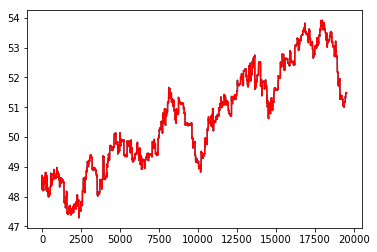

In [261]:
#arima_static_predictions, error = static_ARIMA(example_spread, 5, 0, 3, train_val_split)

In [212]:
p_grid = [2, 3, 4, 5]
q_grid = [1, 2, 3, 4, 5]
best_predictions = None
best_error = 9999
for p in p_grid:
    for q in q_grid:
        print('------------')
        print('({},0,{}) score:'.format(p,q))
        predictions, error = static_ARIMA(example_spread, p, 0, q, train_val_split)
        if error < best_error:
            best_error = error
            best_predictions = predictions
            best_config = (p, 0, q)

------------
(2,0,1) score:
Val MSE: 8.863E-02
Val RMSE: 2.977E-01
------------
(2,0,2) score:
Val MSE: 8.863E-02
Val RMSE: 2.977E-01
------------
(2,0,3) score:
Val MSE: 8.868E-02
Val RMSE: 2.978E-01
------------
(2,0,4) score:
Val MSE: 8.863E-02
Val RMSE: 2.977E-01
------------
(2,0,5) score:
Val MSE: 8.863E-02
Val RMSE: 2.977E-01
------------
(3,0,1) score:
Val MSE: 8.863E-02
Val RMSE: 2.977E-01
------------
(3,0,2) score:
Val MSE: 8.834E-02
Val RMSE: 2.972E-01
------------
(3,0,3) score:
Val MSE: 8.844E-02
Val RMSE: 2.974E-01
------------
(3,0,4) score:
Val MSE: 8.864E-02
Val RMSE: 2.977E-01
------------
(3,0,5) score:
Val MSE: 9.021E-02
Val RMSE: 3.003E-01
------------
(4,0,1) score:
Val MSE: 8.827E-02
Val RMSE: 2.971E-01
------------
(4,0,2) score:
Val MSE: 8.928E-02
Val RMSE: 2.988E-01
------------
(4,0,3) score:
Val MSE: 8.884E-02
Val RMSE: 2.981E-01
------------
(4,0,4) score:
Val MSE: 8.848E-02
Val RMSE: 2.975E-01
------------
(4,0,5) score:
Val MSE: 8.852E-02
Val RMSE: 2.975

In [213]:
print('Best configuration: ', best_config)

Best configuration:  (5, 0, 3)


In [38]:
print('RMSE for predicting the spread pct change is {}'.format(np.sqrt(0.023)))

RMSE for predicting the spread pct change is 0.15165750888103102


In [ ]:
# see persistent forecasting
# try with more delays

Long threshold:  0.2301860865257578
Short threshold:  -0.23053506421324
Accumulated return: 0.0 %


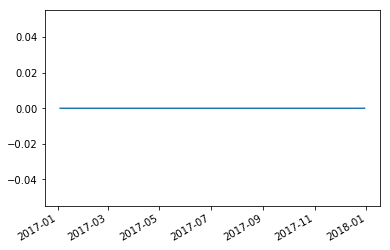

In [315]:
ret_example, cumret_example, summary_example = forecast_spread_trading(X=x_val, Y=y_val,
                                                       spread_test=spread_val,
                                                       spread_train=example_spread[:train_val_split],
                                                       beta=beta, 
                                                       predictions=arima_static_predictions,
                                                       lag=1)
print('Accumulated return: {} %'.format(cumret_example[-1]*100))
cumret_example.plot()

In [342]:
summary_example.head()#.trading_days[summary_example.trading_days!=0]

,position_during_day,predicted_change(%),predicted_direction,prediction(t),ret,ret_with_costs,spread(t),trading_days,true_direction
2017-01-03 14:35:00,0.0,0.000000,0,48.261079,0.0,0.0,48.647090,0,NaN
2017-01-03 14:40:00,0.0,-0.072367,-1,48.611886,0.0,0.0,48.703066,0,1
2017-01-03 14:45:00,0.0,-0.023043,-1,48.691844,0.0,0.0,48.718293,0,1
2017-01-03 14:50:00,0.0,-0.016692,-1,48.710161,0.0,0.0,48.239293,0,-1
2017-01-03 14:55:00,0.0,0.121253,1,48.297785,0.0,0.0,48.250338,0,1


In [318]:
summary_example['predicted_change(%)'][summary_example['predicted_change(%)']>0].sort_values(ascending=False).head()

2017-09-13 14:30:00    0.175065
2017-09-19 19:25:00    0.123547
2017-03-16 18:50:00    0.116855
2017-02-01 16:45:00    0.108065
2017-12-21 18:05:00    0.105310
Name: predicted_change(%), dtype: float64

# Trying some ANN based models

In [34]:
def plot_loss(history, title):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    
    plt.plot(history['loss'], label = "training")
    plt.plot(history['val_loss'], label = "validation")

## MLP

In [28]:
def grid_search_MLP(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    """
    Funcion to perform grid search.
    """
    models = [] # saves parameters and score for every model
    best_model = {'neurons':0,'mse':9999,'mae':9999, 'history':None, 'predictions':None} 
    for i,neurons in enumerate(hidden_nodes):
        history, score, predictions = apply_MLP(X, y, validation_data, n_in, neurons, epochs,
                                                optimizer, loss_fct)
        
        # save reference to best model
        # score is loss! So being smaller is actually better
        if score['val'][1] < best_model['mae']:
            # update best model
            best_model['neurons']=neurons
            best_model['mse']=score['val'][0]
            best_model['mae']=score['val'][1]
            best_model['history']=history
            best_model['predictions']=predictions

        # simply save score
        # this way we save a bit of memory
        models.append({'neurons':neurons,
                       'mse':score['val'][0],
                       'mae':score['val'][1]
                      })
   
    print('The best model obtained a MAE score of ', best_model['mae'])
    
    return models, best_model    

In [24]:
# parameters
n_in = 10
epochs = 200
hidden_nodes = [10]#[2,5,10,20]
loss_fct = 'mse'
optimizer = 'adam'
train_val_split = '2017-01-01' # initial date

In [25]:
example = pairs[1]#[5]
example_spread = example[2]['spread']

# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date

# normalize data
example_spread = example[2]['spread']
standardization_dict = {'mean':example_spread[:train_val_split].mean(),
                        'std':np.std(example_spread[:train_val_split])}
example_spread_norm = (example_spread - standardization_dict['mean'])/standardization_dict['std']

# spread validation
spread_val = example_spread[train_val_split:]

# prepare data
forecasting_data = forecasting_trader.series_to_supervised(list(example_spread_norm), example_spread_norm.index, n_in, 1,
                                        dropnan=True)

In [26]:
# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(X_series.values)
y = np.asarray(y_series.values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X_series_train.values
X_val = X_series_val.values
y_train = y_series_train.values
y_val = y_series_val.values

In [332]:
# train one configuration
start = time.time()
mlp_history, mlp_score, mlp_predictions = forecasting_trader.apply_MLP(X_train, y_train, (X_val, y_val), n_in,
                                                                       hidden_nodes, epochs, 
                                                                       optimizer, loss_fct)
mlp_predictions = pd.Series(data=mlp_predictions.flatten(), index=y_series_val.index)
end = time.time()
print('Finished model fitting... Time elapsed: ',(end - start))

mlp_predictions_destandardized = destandardize(mlp_predictions, standardization_dict['mean'],
                                               standardization_dict['std'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Train on 156506 samples, validate on 19506 samples
Epoch 1/200
 - 1s - loss: 0.1052 - mean_absolute_error: 0.1276 - val_loss: 0.0082 - val_mean_absolute_error: 0.0696
Epoch 2/200
 - 1s - loss: 0.0021 - mean_absolute_error: 0.0277 - val_loss: 0.0015 - val_mean_absolute_error: 0.0281
Epoch 3/200
 - 1s - loss: 0.0015 - mean_absolute_error: 0.0218 - val_loss: 7.1228e-04 - val_mean_absolute_error: 0.0189
Epoch 4/200
 - 1s - loss: 0.0014 - mean_absolute_error: 0.0207 - val_loss: 6.9932e-04 - val_mean_absolute_error: 0.0188
Epoch 5/200
 - 1s

Epoch 62/200
 - 2s - loss: 3.5581e-04 - mean_absolute_error: 0.0096 - val_loss: 5.7753e-05 - val_mean_absolute_error: 0.0025
Epoch 63/200
 - 1s - loss: 3.5259e-04 - mean_absolute_error: 0.0095 - val_loss: 5.7792e-05 - val_mean_absolute_error: 0.0026
Epoch 64/200
 - 1s - loss: 3.5226e-04 - mean_absolute_error: 0.0095 - val_loss: 5.7574e-05 - val_mean_absolute_error: 0.0026
Epoch 65/200
 - 1s - loss: 3.5212e-04 - mean_absolute_error: 0.0095 - val_loss: 5.7507e-05 - val_mean_absolute_error: 0.0026
Epoch 66/200
 - 1s - loss: 3.5139e-04 - mean_absolute_error: 0.0095 - val_loss: 5.7311e-05 - val_mean_absolute_error: 0.0025
Epoch 67/200
 - 1s - loss: 3.5210e-04 - mean_absolute_error: 0.0096 - val_loss: 5.6943e-05 - val_mean_absolute_error: 0.0025
Epoch 68/200
 - 1s - loss: 3.4957e-04 - mean_absolute_error: 0.0094 - val_loss: 5.6918e-05 - val_mean_absolute_error: 0.0025
Epoch 69/200
 - 1s - loss: 3.4887e-04 - mean_absolute_error: 0.0094 - val_loss: 5.6795e-05 - val_mean_absolute_error: 0.0024


Epoch 128/200
 - 2s - loss: 3.2828e-04 - mean_absolute_error: 0.0087 - val_loss: 5.6243e-05 - val_mean_absolute_error: 0.0030
Epoch 129/200
 - 2s - loss: 3.3132e-04 - mean_absolute_error: 0.0088 - val_loss: 5.5991e-05 - val_mean_absolute_error: 0.0029
Epoch 130/200
 - 1s - loss: 3.2582e-04 - mean_absolute_error: 0.0087 - val_loss: 5.5936e-05 - val_mean_absolute_error: 0.0029
Epoch 131/200
 - 3s - loss: 3.2896e-04 - mean_absolute_error: 0.0088 - val_loss: 6.1223e-05 - val_mean_absolute_error: 0.0037
Epoch 132/200
 - 2s - loss: 3.2744e-04 - mean_absolute_error: 0.0087 - val_loss: 5.6002e-05 - val_mean_absolute_error: 0.0029
Epoch 133/200
 - 2s - loss: 3.2716e-04 - mean_absolute_error: 0.0087 - val_loss: 5.6111e-05 - val_mean_absolute_error: 0.0029
Epoch 134/200
 - 2s - loss: 3.2749e-04 - mean_absolute_error: 0.0087 - val_loss: 5.6232e-05 - val_mean_absolute_error: 0.0030
Epoch 135/200
 - 2s - loss: 3.2802e-04 - mean_absolute_error: 0.0087 - val_loss: 5.6548e-05 - val_mean_absolute_error:

 - 2s - loss: 3.1904e-04 - mean_absolute_error: 0.0083 - val_loss: 5.4265e-05 - val_mean_absolute_error: 0.0025
Epoch 194/200
 - 2s - loss: 3.2129e-04 - mean_absolute_error: 0.0086 - val_loss: 5.3636e-05 - val_mean_absolute_error: 0.0023
Epoch 195/200
 - 2s - loss: 3.1820e-04 - mean_absolute_error: 0.0084 - val_loss: 5.3419e-05 - val_mean_absolute_error: 0.0022
Epoch 196/200
 - 1s - loss: 3.1758e-04 - mean_absolute_error: 0.0084 - val_loss: 5.3395e-05 - val_mean_absolute_error: 0.0022
Epoch 197/200
 - 2s - loss: 3.1769e-04 - mean_absolute_error: 0.0084 - val_loss: 5.3417e-05 - val_mean_absolute_error: 0.0022
Epoch 198/200
 - 2s - loss: 3.1804e-04 - mean_absolute_error: 0.0084 - val_loss: 5.3492e-05 - val_mean_absolute_error: 0.0022
Epoch 199/200
 - 1s - loss: 3.1744e-04 - mean_absolute_error: 0.0084 - val_loss: 5.3474e-05 - val_mean_absolute_error: 0.0022
Epoch 200/200
 - 1s - loss: 3.1690e-04 - mean_absolute_error: 0.0084 - val_loss: 5.3525e-05 - val_mean_absolute_error: 0.0022
------

Val RMSE:  0.03833721090884073


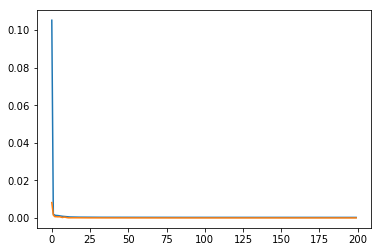

In [373]:
print('Val RMSE: ', np.sqrt(mean_squared_error(mlp_predictions_destandardized, spread_val)))
plot_loss(mlp_history, 'mlp_loss')

Long threshold:  0.2301860865257578
Short threshold:  -0.23053506421324
Accumulated return: -0.2684949404407111 %


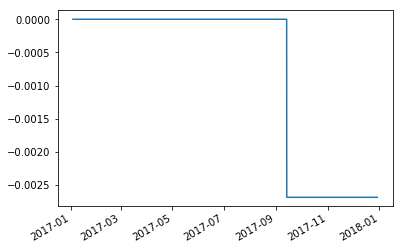

In [346]:
ret_example, cumret_example, summary_example = forecasting_trader.forecast_spread_trading(
                                                       X=example[2]['X_train'][train_val_split:],
                                                       Y=example[2]['Y_train'][train_val_split:],
                                                       spread_test=spread_val,
                                                       spread_train=example_spread[:train_val_split],
                                                       beta=beta, 
                                                       predictions=mlp_predictions_destandardized,
                                                       lag=1)
print('Accumulated return: {} %'.format(cumret_example[-1]*100))
cumret_example.plot()

In [348]:
summary_example[summary_example.position_during_day!=0]

,position_during_day,predicted_change(%),predicted_direction,prediction(t),ret,ret_with_costs,spread(t),trading_days,true_direction
2017-09-13 14:30:00,1.0,0.265458,1,51.755285,0.000000,0.000000,51.618261,0,0
2017-09-13 14:35:00,1.0,0.062695,1,51.650623,0.000000,0.000000,51.621263,0,1
2017-09-13 14:40:00,1.0,0.095468,1,51.670545,-0.000189,-0.002685,51.612041,1,-1


In [364]:
# train one configuration
start = time.time()
mlp_history_2, mlp_score, mlp_predictions_2 = forecasting_trader.apply_MLP(X_train, y_train, (X_val, y_val),
                                                                           n_in, [10,10],
                                                                           epochs, optimizer, loss_fct)
mlp_predictions_2 = pd.Series(data=mlp_predictions_2.flatten(), index=y_series_val.index)
end = time.time()
print('Finished model fitting... Time elapsed: ',(end - start))

mlp_predictions_destandardized_2 = destandardize(mlp_predictions_2, standardization_dict['mean'],
                                               standardization_dict['std'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_20 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________
Train on 156506 samples, validate on 19506 samples
Epoch 1/200
 - 2s - loss: 0.0518 - mean_absolute_error: 0.0751 - val_loss: 4.9909e-04 - val_mean_absolute_error: 0.0168
Epoch 2/200
 - 2s - loss: 9.1127e-04 - mean_absolute_error: 0.0178 - val_loss: 2.2201e-04 - val_mean_absolute_error: 0.0100
Epoch 3/200
 - 1s - loss: 6.7130e-04 - mean_absolute_error: 0.0145 - val_loss: 1.0818e-04 - val_mean_absolute_err

Epoch 61/200
 - 2s - loss: 3.7274e-04 - mean_absolute_error: 0.0102 - val_loss: 6.8514e-05 - val_mean_absolute_error: 0.0040
Epoch 62/200
 - 1s - loss: 3.7428e-04 - mean_absolute_error: 0.0102 - val_loss: 6.5949e-05 - val_mean_absolute_error: 0.0039
Epoch 63/200
 - 2s - loss: 3.8139e-04 - mean_absolute_error: 0.0105 - val_loss: 6.5994e-05 - val_mean_absolute_error: 0.0039
Epoch 64/200
 - 2s - loss: 3.8239e-04 - mean_absolute_error: 0.0106 - val_loss: 6.3255e-05 - val_mean_absolute_error: 0.0036
Epoch 65/200
 - 1s - loss: 3.7769e-04 - mean_absolute_error: 0.0105 - val_loss: 6.3995e-05 - val_mean_absolute_error: 0.0038
Epoch 66/200
 - 1s - loss: 3.7427e-04 - mean_absolute_error: 0.0103 - val_loss: 6.2669e-05 - val_mean_absolute_error: 0.0037
Epoch 67/200
 - 1s - loss: 3.7280e-04 - mean_absolute_error: 0.0103 - val_loss: 6.3299e-05 - val_mean_absolute_error: 0.0037
Epoch 68/200
 - 1s - loss: 3.8146e-04 - mean_absolute_error: 0.0105 - val_loss: 6.1796e-05 - val_mean_absolute_error: 0.0035


Epoch 127/200
 - 1s - loss: 3.5737e-04 - mean_absolute_error: 0.0098 - val_loss: 6.7554e-05 - val_mean_absolute_error: 0.0038
Epoch 128/200
 - 1s - loss: 3.6023e-04 - mean_absolute_error: 0.0099 - val_loss: 6.8273e-05 - val_mean_absolute_error: 0.0039
Epoch 129/200
 - 1s - loss: 3.5470e-04 - mean_absolute_error: 0.0097 - val_loss: 6.5019e-05 - val_mean_absolute_error: 0.0037
Epoch 130/200
 - 2s - loss: 3.5877e-04 - mean_absolute_error: 0.0097 - val_loss: 6.4527e-05 - val_mean_absolute_error: 0.0037
Epoch 131/200
 - 2s - loss: 3.5935e-04 - mean_absolute_error: 0.0098 - val_loss: 6.5030e-05 - val_mean_absolute_error: 0.0037
Epoch 132/200
 - 2s - loss: 3.5753e-04 - mean_absolute_error: 0.0098 - val_loss: 6.4335e-05 - val_mean_absolute_error: 0.0037
Epoch 133/200
 - 2s - loss: 3.5711e-04 - mean_absolute_error: 0.0098 - val_loss: 6.3505e-05 - val_mean_absolute_error: 0.0037
Epoch 134/200
 - 2s - loss: 3.5375e-04 - mean_absolute_error: 0.0097 - val_loss: 6.2743e-05 - val_mean_absolute_error:

 - 1s - loss: 3.7011e-04 - mean_absolute_error: 0.0102 - val_loss: 7.4030e-05 - val_mean_absolute_error: 0.0044
Epoch 193/200
 - 1s - loss: 3.7174e-04 - mean_absolute_error: 0.0102 - val_loss: 8.1246e-05 - val_mean_absolute_error: 0.0047
Epoch 194/200
 - 1s - loss: 3.8739e-04 - mean_absolute_error: 0.0107 - val_loss: 8.6941e-05 - val_mean_absolute_error: 0.0050
Epoch 195/200
 - 1s - loss: 3.8299e-04 - mean_absolute_error: 0.0105 - val_loss: 8.9368e-05 - val_mean_absolute_error: 0.0050
Epoch 196/200
 - 1s - loss: 3.8984e-04 - mean_absolute_error: 0.0107 - val_loss: 1.0247e-04 - val_mean_absolute_error: 0.0056
Epoch 197/200
 - 1s - loss: 3.9563e-04 - mean_absolute_error: 0.0108 - val_loss: 1.0105e-04 - val_mean_absolute_error: 0.0054
Epoch 198/200
 - 1s - loss: 3.9504e-04 - mean_absolute_error: 0.0108 - val_loss: 1.2558e-04 - val_mean_absolute_error: 0.0063
Epoch 199/200
 - 1s - loss: 4.0247e-04 - mean_absolute_error: 0.0110 - val_loss: 9.2039e-05 - val_mean_absolute_error: 0.0050
Epoch 

AttributeError: 'Series' object has no attribute 'flatten'

Val RMSE:  0.05303094481495355


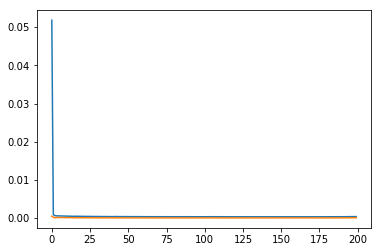

In [372]:
print('Val RMSE: ', np.sqrt(mean_squared_error(mlp_predictions_destandardized_2, spread_val)))
plot_loss(mlp_history_2, 'mlp_loss')

Long threshold:  0.2301860865257578
Short threshold:  -0.23053506421324
Accumulated return: 3.054406949938948 %


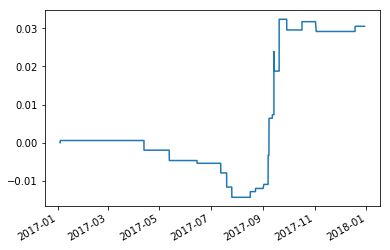

In [368]:
ret_example, cumret_example, summary_example = forecasting_trader.forecast_spread_trading(
                                                       X=example[2]['X_train'][train_val_split:],
                                                       Y=example[2]['Y_train'][train_val_split:],
                                                       spread_test=spread_val,
                                                       spread_train=example_spread[:train_val_split],
                                                       beta=beta, 
                                                       predictions=mlp_predictions_destandardized_2,
                                                       lag=1)
print('Accumulated return: {} %'.format(cumret_example[-1]*100))
cumret_example.plot()

# Grid Search

**Load models run in the server**

In [149]:
def read_models(path='models/'):
    all_models = [] # Creates an empty list
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".pkl"):
                with open(path+file, 'rb') as f:
                    models = pickle.load(f)
                all_models.append(models)
                
    return all_models

def run_trained_models(pairs, train_val_split='2017-01-01', lag=1, low_quantile=0.15, high_quantile=0.85):
    
    # initialize storage variables
    best_score = -99999
    best_model = None
    
    all_models = read_models()
    for configuration in all_models:#[:1]:
        config = configuration[-1]
        print('\n###################### NEW CONFIGURATION ######################')
        print('Configuration: ', config)
        configuration_cumret = list()
        for pair_i in range(len(configuration)-1):
            print('\nPair loaded: {}_{}:'.format(configuration[pair_i]['leg1'], configuration[pair_i]['leg2']))
            print('Check pairs: {}_{}.'.format(pairs[pair_i][0], pairs[pair_i][1]))
            predictions = configuration[pair_i]['predictions']
            ret, cumret, summary = forecasting_trader.forecast_spread_trading(
                                                       X=pairs[pair_i][2]['X_train'][train_val_split:],
                                                       Y=pairs[pair_i][2]['Y_train'][train_val_split:],
                                                       spread_test=pairs[pair_i][2]['spread'][train_val_split:],
                                                       spread_train=pairs[pair_i][2]['spread'][:train_val_split],
                                                       beta=pairs[pair_i][2]['coint_coef'],
                                                       predictions=predictions,
                                                       lag=lag,
                                                       low_quantile=low_quantile,
                                                       high_quantile=high_quantile)
            print('Accumulated return: {:.2f}%'.format(cumret[-1]*100))
            configuration_cumret.append(cumret[-1]*100)
        
        print('\nCONFIGURATION MEAN ROI: {:.2f}%'.format(np.mean(configuration_cumret)))
        if np.mean(configuration_cumret)>best_score:
            best_score = np.mean(configuration_cumret)
            best_model = config
    
    return all_models, (best_model, best_score)

def display_forecasting_score(models):
    
    # initialize storage variables
    best_score = 99999
    best_model = None
    
    all_models = models
    for configuration in all_models:
        config = configuration[-1]
        print('\n###################### NEW CONFIGURATION ######################')
        print('Configuration: ', config)
        mae_train, mse_train = list(), list()
        mae_val, mse_val = list(), list()
        for pair_i in range(len(configuration)-1):
            #print('\nPair loaded: {}_{}:'.format(configuration[pair_i]['leg1'], configuration[pair_i]['leg2']))
            score_train = configuration[pair_i]['score']['train']
            score_val = configuration[pair_i]['score']['val']
            #print('MAE: {:.2f}%'.format(score[1]))
            mse_train.append(score_train[0])
            mae_train.append(score_train[1])
            mse_val.append(score_val[0])
            mae_val.append(score_val[1])
            
        if (np.mean(mse_val))<best_score:
            best_score = np.mean(mse_val)
            best_model = config
                
        print('\nCONFIGURATION TRAIN MSE ERROR: {:.4f}'.format(np.mean(mse_train)))
        print('CONFIGURATION TRAIN MAE ERROR: {:.4f}'.format(np.mean(mae_train)))
        print('\nCONFIGURATION VAL MSE ERROR: {:.4f}'.format(np.mean(mse_val)))
        print('CONFIGURATION VAL MAE ERROR: {:.4f}'.format(np.mean(mae_val)))
    
    return (best_model, best_score)

def run_specific_model(n_in, hidden_nodes, pairs, path='models/', train_val_split='2017-01-01', lag=1,
                       low_quantile=0.10, high_quantile=0.90):
    
    nodes_name = str(hidden_nodes[0]) + '*2' if len(hidden_nodes) > 1 else str(hidden_nodes[0])
    file_name = 'models_n_in-'+str(n_in)+'_hidden_nodes-'+nodes_name+'.pkl'
    
    with open(path+file_name, 'rb') as f:
        model = pickle.load(f)
    
    model_cumret = list()
    config = model[-1]
    for pair_i in range(len(model)-1):
        print('\nPair loaded: {}_{}:'.format(model[pair_i]['leg1'], model[pair_i]['leg2']))
        predictions = model[pair_i]['predictions']
        ret, cumret, summary = forecasting_trader.forecast_spread_trading(
                                                       X=pairs[pair_i][2]['X_train'][train_val_split:],
                                                       Y=pairs[pair_i][2]['Y_train'][train_val_split:],
                                                       spread_test=pairs[pair_i][2]['spread'][train_val_split:],
                                                       spread_train=pairs[pair_i][2]['spread'][:train_val_split],
                                                       beta=pairs[pair_i][2]['coint_coef'],
                                                       predictions=predictions,
                                                       lag=lag,
                                                       low_quantile=low_quantile,
                                                       high_quantile=high_quantile)
        print('Accumulated return: {:.2f}%'.format(cumret[-1]*100))
        model_cumret.append(cumret[-1]*100)
        #(predictions-pairs[pair_i][2]['spread'][train_val_split:]).plot()
        
    print('\nModel mean ROI: {:.2f}%'.format(np.mean(model_cumret)))
    
    return model, ret, cumret, summary

In [150]:
model, ret, cumret, summary = run_specific_model(10, [5], pairs, low_quantile=0.10, high_quantile=0.90, lag=1)


Pair loaded: DBA_GCC:
Long threshold: 1.23
Short threshold: -1.25
Accumulated return: 1.29%

Pair loaded: RJA_RJZ:
Long threshold: 6.25
Short threshold: -6.26
Accumulated return: 0.00%

Pair loaded: GSG_USL:
Long threshold: 14.06
Short threshold: -14.47
Accumulated return: 1.67%

Pair loaded: DZZ_GLL:
Long threshold: 7.48
Short threshold: -8.09
Accumulated return: 18.47%

Model mean ROI: 5.36%


In [89]:
models, best = run_trained_models(pairs, low_quantile=0.05, high_quantile=0.95)


###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [5, 5], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 5, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.63
Short threshold: -1.66
Accumulated return: -1.18 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 12.01
Short threshold: -11.86
Accumulated return: 0.00 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 30.38
Short threshold: -31.42
Accumulated return: 1.39 %

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 13.44
Short threshold: -15.06
Accumulated return: 0.00 %

CONFIGURATION MEAN ROI: 0.05

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [7, 7], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 10, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.6

Accumulated return: 1.35 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 12.01
Short threshold: -11.86
Accumulated return: 0.00 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 30.38
Short threshold: -31.42
Accumulated return: 0.06 %

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 13.44
Short threshold: -15.06
Accumulated return: 2.03 %

CONFIGURATION MEAN ROI: 0.86

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [7], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 7, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.63
Short threshold: -1.66
Accumulated return: 1.42 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 12.01
Short threshold: -11.86
Accumulated return: 0.00 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 30.38
Short threshold: -31.42
Accumulated return: 1.36 %

Pair loaded: DZZ_GLL:


Accumulated return: 0.00 %

CONFIGURATION MEAN ROI: 0.27

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [3, 3], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 3, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.63
Short threshold: -1.66
Accumulated return: 1.02 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 12.01
Short threshold: -11.86
Accumulated return: -0.25 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 30.38
Short threshold: -31.42
Accumulated return: 0.20 %

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 13.44
Short threshold: -15.06
Accumulated return: 4.99 %

CONFIGURATION MEAN ROI: 1.49

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [7], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 3, 'optimizer': 'adam', 'epochs': 200}

Pair loade

In [113]:
models, best = run_trained_models(pairs, low_quantile=0.10, high_quantile=0.90)


###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [5, 5], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 5, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.23
Short threshold: -1.25
Accumulated return: -4.00%

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 6.25
Short threshold: -6.26


KeyboardInterrupt: 

In [88]:
models, best = run_trained_models(pairs, low_quantile=0.15, high_quantile=0.85)


###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [5, 5], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 5, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.01
Short threshold: -1.02
Accumulated return: -6.67 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 4.31
Short threshold: -4.37
Accumulated return: -0.25 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 8.75
Short threshold: -8.94
Accumulated return: 0.10 %

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 5.42
Short threshold: -5.69
Accumulated return: 4.31 %

CONFIGURATION MEAN ROI: -0.63

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [7, 7], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 10, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.01
Sh

Accumulated return: -8.18 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 8.75
Short threshold: -8.94
Accumulated return: 0.26 %

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 5.42
Short threshold: -5.69
Accumulated return: 18.15 %

CONFIGURATION MEAN ROI: 2.13

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [7], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 7, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.01
Short threshold: -1.02
Accumulated return: -2.73 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 4.31
Short threshold: -4.37
Accumulated return: -1.42 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 8.75
Short threshold: -8.94
Accumulated return: 0.23 %

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 5.42
Short threshold: -5.69
Accumulated return: -0.61 %

CONFIGURATION MEAN ROI: -1.

Accumulated return: -4.17 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 4.31
Short threshold: -4.37
Accumulated return: -8.18 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 8.75
Short threshold: -8.94
Accumulated return: 0.03 %

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 5.42
Short threshold: -5.69
Accumulated return: 8.46 %

CONFIGURATION MEAN ROI: -0.96

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [7], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 3, 'optimizer': 'adam', 'epochs': 200}

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.01
Short threshold: -1.02
Accumulated return: -8.01 %

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 4.31
Short threshold: -4.37
Accumulated return: -0.25 %

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 8.75
Short threshold: -8.94
Accumulated return: -1.99 %

Pair loaded: DZZ_GLL:
Chec

**Forecasting score**

In [144]:
best_score = display_forecasting_score(models)


###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [5, 5], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 5, 'optimizer': 'adam', 'epochs': 200}

CONFIGURATION TRAIN MSE ERROR: 0.0026
CONFIGURATION TRAIN MAE ERROR: 0.0300

CONFIGURATION VAL MSE ERROR: 0.0007
CONFIGURATION VAL MAE ERROR: 0.0159

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [7, 7], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 10, 'optimizer': 'adam', 'epochs': 200}

CONFIGURATION TRAIN MSE ERROR: 0.0030
CONFIGURATION TRAIN MAE ERROR: 0.0328

CONFIGURATION VAL MSE ERROR: 0.0007
CONFIGURATION VAL MAE ERROR: 0.0156

###################### NEW CONFIGURATION ######################
Configuration:  {'loss_fct': 'mse', 'hidden_nodes': [5, 5], 'n_out': 1, 'train_val_split': '2017-01-01', 'n_in': 10, 'optimizer': 'adam', 'epochs': 200}

CONFIGURATION TRAIN MSE ERROR: 0.0028
CONFIGUR

In [115]:
best_score

({'epochs': 200,
  'hidden_nodes': [7],
  'loss_fct': 'mse',
  'n_in': 5,
  'n_out': 1,
  'optimizer': 'adam',
  'train_val_split': '2017-01-01'},
 0.0005760316674080738)

In [ ]:
# grid search
models_mlp, best_model_mlp = grid_search_MLP(X_train, y_train, (X_val, y_val), n_in, hidden_nodes,
                                             epochs, optimizer, loss_fct)
mlp_predictions = pd.Series(data=best_model_mlp['predictions'].flatten(), index=y_series_val.index)

In [202]:
def return_dict(i):
    example={'i':i}
    return example

testing = []
for i in range(3):
    example = return_dict(i)
    testing.append(example)
testing

[{'i': 0}, {'i': 1}, {'i': 2}]

In [ ]:
# grid search with 2 layers
models_mlp, best_model_mlp = grid_search_MLP(X_train, y_train, (X_val, y_val), n_in, hidden_nodes,
                                             epochs, optimizer, loss_fct)
mlp_predictions = pd.Series(data=best_model_mlp['predictions'].flatten(), index=y_series_val.index)

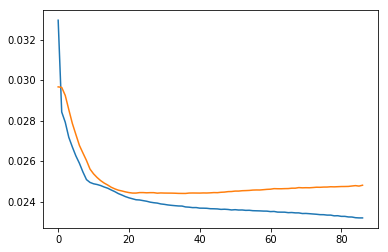

In [97]:
plot_loss(mlp_history, 'mlp_loss')

**Try trading using simple MLP model**

In [714]:
# perceber como é que melhora tanto quando eu baixo o threshold
# - ver accuracy da direção - parece ser a mesma para diferentes threhsolds.
# Para -70,70 a accuracy é muito boa mas as cum returns nem por isso. Por ter menos trades pode não compensar
# usar este parametro para treinar a rede possivelmente pode ser melhor - mudar para classificação
# criar threshold adaptativo

**Naive Benchmark**

In [1010]:
for i in range(len(pairs)):
    print('---------------------------------------------------------------')
    print('Pair {}: '.format(i))
    pnl, ret, summary, sharpe = forecast_trading(models[i]['info']['X_train'][train_val_split:],
                                                 models[i]['info']['Y_train'][train_val_split:],
                                                 models[i]['info']['spread'][train_val_split:],
                                                 models[i]['info']['coint_coef'],
                                                 #models[i]['predictions'],
                                                 pd.Series(data=[models[i]['info']['spread'][train_val_split:].mean()]*len(models[i]['info']['spread'][train_val_split:]),
                                                           index=models[i]['info']['spread'][train_val_split:].index),
                                                 0, 0,
                                                 auto_threshold=True,
                                                 standardization_dict=models[i]['standardization_dict'])
    total_roi = (np.cumprod(1 + ret) - 1).iloc[-1]* 100
    print('Cum return:', total_roi)
    print('Annual ROI: ', ((1 + (total_roi / 100)) ** (1 / float(2)) - 1) * 100)

---------------------------------------------------------------
Pair 0: 
Sharpe:  1.7281855125483356
Cum return: 16.38094477687786
Annual ROI:  7.880000360065753
---------------------------------------------------------------
Pair 1: 
Sharpe:  0.4974207290129881
Cum return: 2.352387676337364
Annual ROI:  1.1693568608288407
---------------------------------------------------------------
Pair 2: 
Sharpe:  1.9935637034669569
Cum return: 15.007650790572914
Annual ROI:  7.241620087805889
---------------------------------------------------------------
Pair 3: 
Sharpe:  0.6658520939439747
Cum return: 4.366259012936857
Annual ROI:  2.1598057030928652
---------------------------------------------------------------
Pair 4: 
Sharpe:  1.0925824547549299
Cum return: 8.197188093753471
Annual ROI:  4.01787735469008
---------------------------------------------------------------
Pair 5: 
Sharpe:  2.308081527036086
Cum return: 30.97043037159446
Annual ROI:  14.44231314142268
---------------------------

IndexError: list index out of range

**MLP performance**

In [1015]:
model_config = {"n_in": 5,
                "n_out": 1,
                "epochs": 200,
                "hidden_nodes":5,
                "loss_fct": "mse",
                "optimizer": "adam",
                "train_val_split": '2016-01-01'}
models = forecasting_trader.train_models(pairs, model_config)

Under construction
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_357 (Dense)            (None, 5)                 30        
_________________________________________________________________
dense_358 (Dense)            (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------
The mse train loss is:  0.050927490430873995
The mae train loss is:  0.1406603857650123
The mse test loss is:  0.010008433333803598
The mae test loss is:  0.0717070910553809
------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_359 (Dense)            (None, 5)                 30        
_____________________________

------------------------------------------------------------
The mse train loss is:  0.03785171032409879
The mae train loss is:  0.13725373783298833
The mse test loss is:  0.028242379463986896
The mae test loss is:  0.12368406635333246
------------------------------------------------------------


In [1016]:
for i in range(len(pairs)):
    print('---------------------------------------------------------------')
    print('Pair {}: '.format(i))
    pnl, ret, summary, sharpe = forecast_trading(models[i]['info']['X_train'][train_val_split:],
                                                 models[i]['info']['Y_train'][train_val_split:],
                                                 models[i]['info']['spread'][train_val_split:],
                                                 models[i]['info']['coint_coef'],
                                                 models[i]['predictions'],
                                                 -1, 1,
                                                 auto_threshold=False,
                                                 standardization_dict=models[i]['standardization_dict'])
    total_roi = (np.cumprod(1 + ret) - 1).iloc[-1]* 100
    print('Cum return:', total_roi)
    print('Annual ROI: ', ((1 + (total_roi / 100)) ** (1 / float(2)) - 1) * 100)

---------------------------------------------------------------
Pair 0: 
Sharpe:  5.146659426840563
Cum return: 44.36132692527133
Annual ROI:  20.150458561451746
---------------------------------------------------------------
Pair 1: 
Sharpe:  4.766546644796725
Cum return: 86.07688282141433
Annual ROI:  36.41000066762492
---------------------------------------------------------------
Pair 2: 
Sharpe:  5.210765330977088
Cum return: 109.26797365843566
Annual ROI:  44.66097388668295
---------------------------------------------------------------
Pair 3: 
Sharpe:  1.7236461640748346
Cum return: 17.20111722151676
Annual ROI:  8.259464815560925
---------------------------------------------------------------
Pair 4: 
Sharpe:  1.86332940960475
Cum return: 19.671718032527362
Annual ROI:  9.39456934991214
---------------------------------------------------------------
Pair 5: 
Sharpe:  3.385119953713335
Cum return: 34.10931827088328
Annual ROI:  15.805577702839212
-------------------------------

In [727]:
summary = summary[(summary['predicted_change(%)']>70) | (summary['predicted_change(%)']<-70)]
acc = len(np.where(summary.predicted_direction == summary.true_direction)[0])/len(summary)*100
acc

72.91666666666666

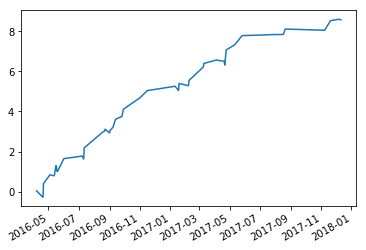

In [728]:
cum_pnl = np.cumsum(summary.pnl)
cum_pnl.plot()

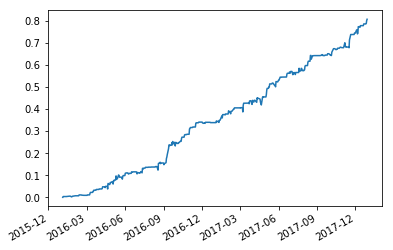

In [729]:
(np.cumprod(1 + ret) - 1).plot()

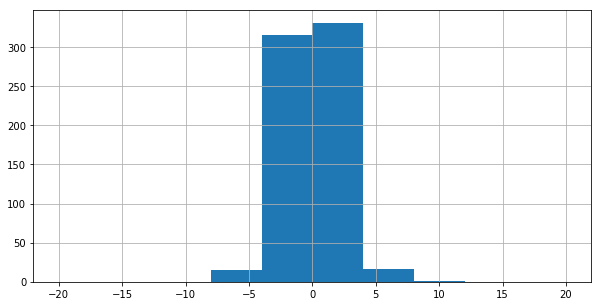

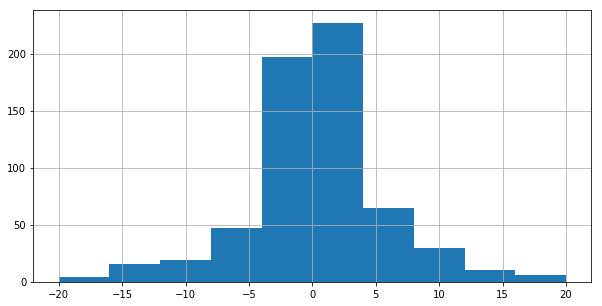

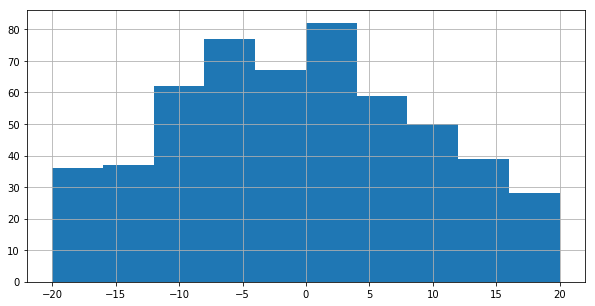

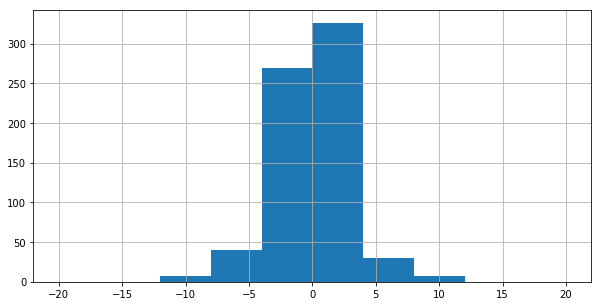

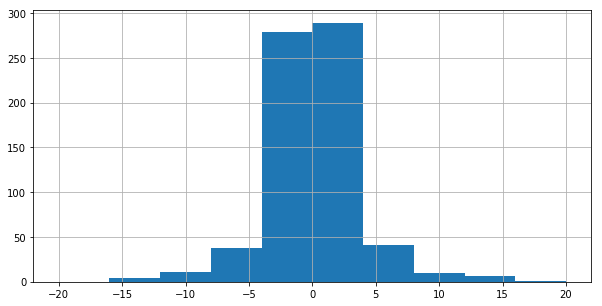

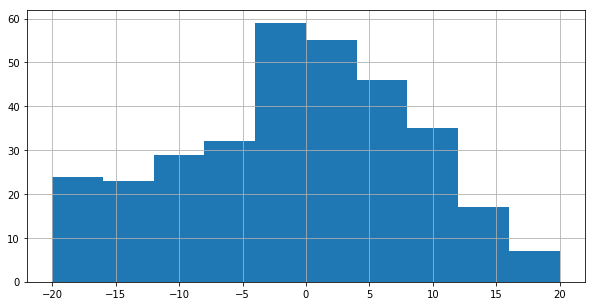

In [543]:
for i in range(6):
    example = pairs[i]
    example_spread = example[2]['spread']
    example_spread = example_spread[train_val_split:][n_in:]
    #print('spread percentage change: ', (example_spread.pct_change()*100).mean())
    plt.figure(figsize=(10,5))
    (example_spread.pct_change()*100).hist(range=(-20, 20))
    #alternative1 = ((example_spread-example_spread.shift(1))/np.std(example_spread)*100).mean()
    #print('alternative 1:', alternative1)

In [ ]:
# try plotting percentage deviations w.r.t std.deviation

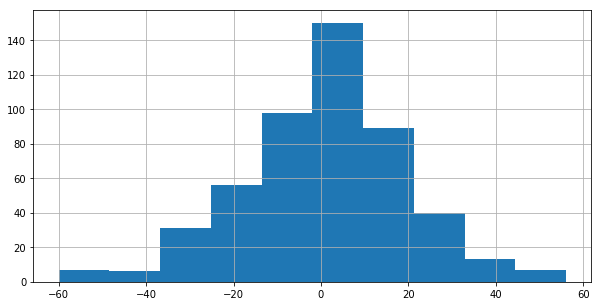

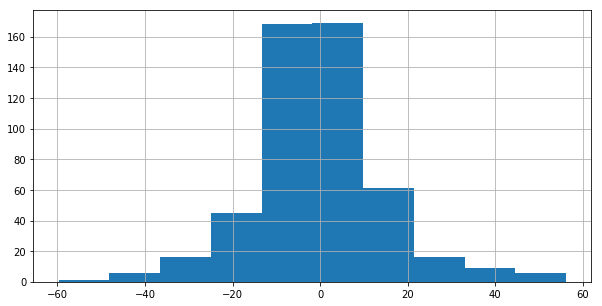

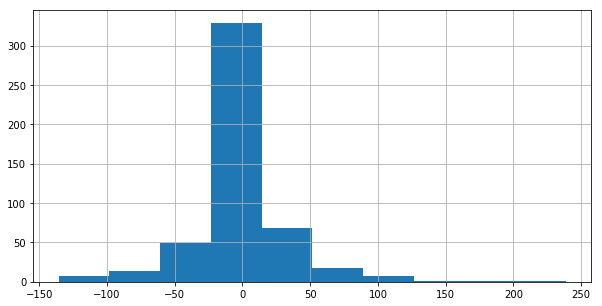

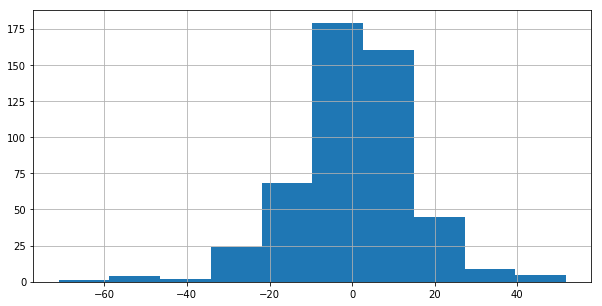

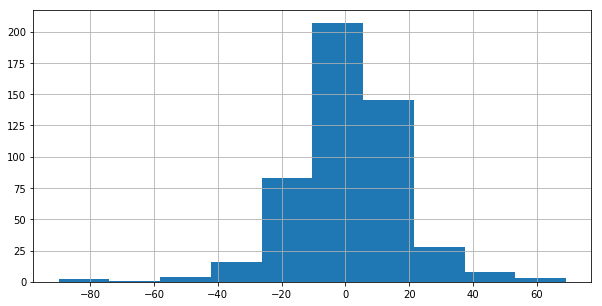

In [753]:
for i in range(6):
    example = pairs[i]
    example_spread = example[2]['spread']
    example_spread = example_spread[train_val_split:][n_in:]
    #print('spread percentage change: ', (example_spread.pct_change()*100).mean())
    plt.figure(figsize=(10,5))
    #(example_spread.pct_change()*100).hist(range=(-20, 20))
    alternative1 = ((example_spread-example_spread.shift(1))/np.std(example_spread)*100)
    alternative1.hist()#range=(-20, 20))

In [758]:
alternative1.describe()

count    497.000000
mean       0.710888
std       17.248188
min      -89.894630
25%       -8.239816
50%        0.964706
75%       10.023167
max       69.142147
dtype: float64

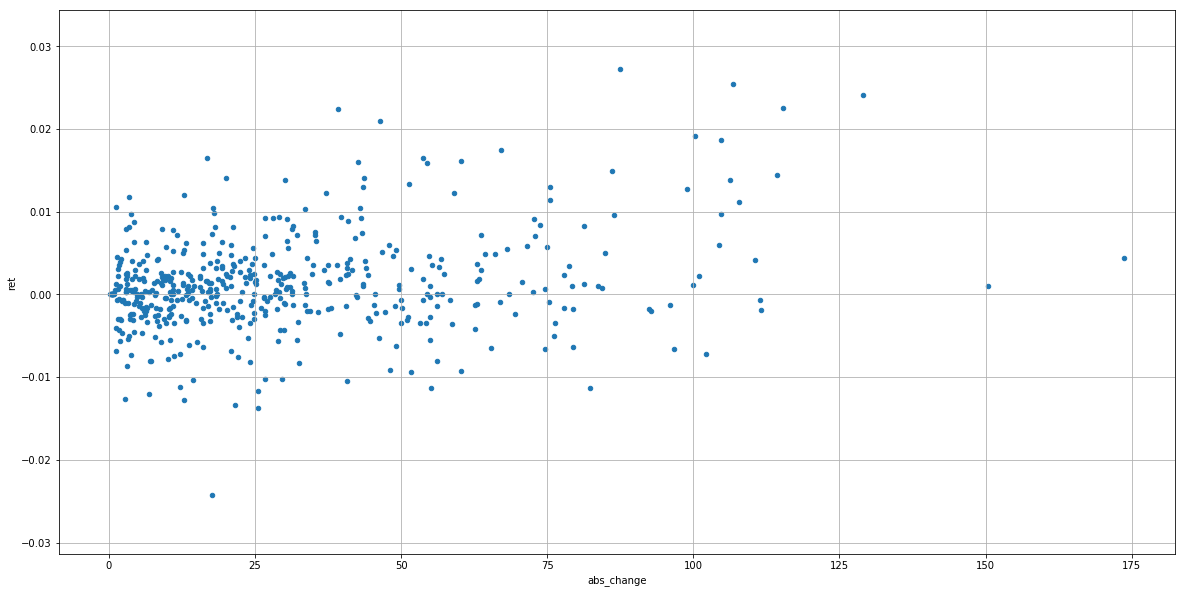

In [637]:
summary['abs_change']=np.abs(summary['predicted_change(%)'])
summary.plot.scatter(x='abs_change', y='ret', figsize=(20,10), grid=True)

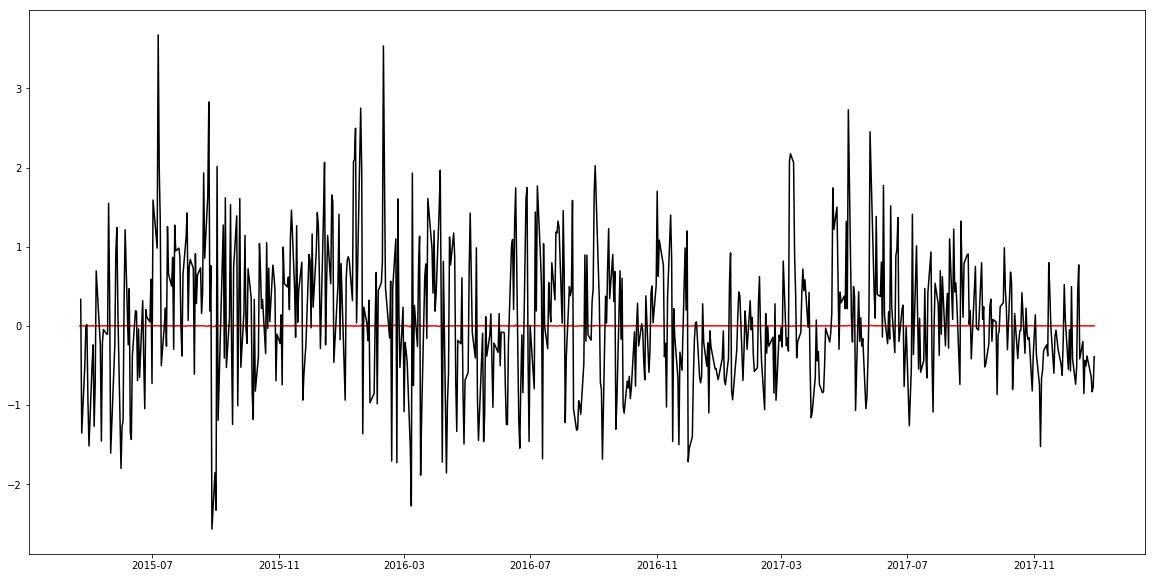

In [524]:
# Rerun y_test!
plt.close()
plt.figure(figsize=(20,10))
plt.plot(summary.ret, color='red')
plt.plot(summary['predicted_spread_change(%)'], color='black')
plt.show()

**Important:** On day n, I will make the prediction for day n, and not for day n+1. 

# Modelling with more complex models

## CNN

In [228]:
def apply_CNN(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape data for conv net
    X = X.reshape((X.shape[0], X.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1]
    
   # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(n_in, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=0)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions

In [229]:
# parameters
n_in = 5
epochs = 200
hidden_nodes = 20
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.66*len(example_spread))

In [230]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [48]:
cnn_history, cnn_score, cnn_predictions = apply_CNN(X_train, y_train, (X_val, y_val), n_in,
                                                   hidden_nodes, epochs, optimizer, loss_fct)
cnn_predictions = pd.Series(data=cnn_predictions.flatten(), index=y_series_val.index)

NameError: name 'apply_CNN' is not defined

The mse test loss is:  0.02458564558011644
The mae test loss is:  0.11168607561027302


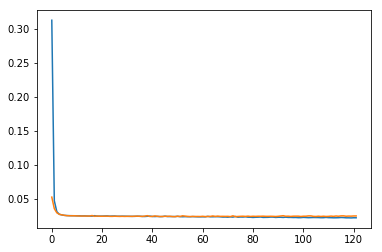

In [232]:
print('The mse test loss is: ', cnn_score[0])
print('The mae test loss is: ', cnn_score[1])
plot_loss(cnn_history, 'cnn_loss')

## RNN

In [312]:
def apply_RNN(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape data for conv net
    X = X.reshape((X.shape[0], X.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1]

    # define model
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation='relu', input_shape=(n_in, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()

    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=0)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions

In [308]:
# parameters
n_in = 10
epochs = 500
hidden_nodes = 50
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.8*len(example_spread))

In [309]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [310]:
rnn_history, rnn_score, rnn_predictions = apply_RNN(X_train, y_train, (X_val, y_val), n_in,
                                                   hidden_nodes, epochs, optimizer, loss_fct)
rnn_predictions = pd.Series(data=rnn_predictions.flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 00085: early stopping
The mse train loss is:  0.01951719157814239
The mae train loss is:  0.09536048861579124
The mse test loss is:  0.03156217736009575
The mae test loss is:  0.13075080855202129


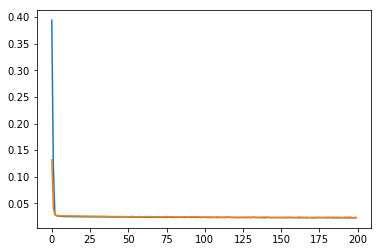

In [300]:
plot_loss(rnn_history, 'rnn_loss')

## CNN-LSTM

In [290]:
from keras.layers import TimeDistributed

def apply_CNN_LSTM(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
    X = X.reshape((X.shape[0], 2, 2, 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], 2, 2, 1))
    y_val = validation_data[1]

    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(hidden_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=1)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions


In [291]:
# parameters
n_in = 4
epochs = 500
hidden_nodes = 50
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.8*len(example_spread))

In [292]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [293]:
cnn_lstm_history, cnn_lstm_score, cnn_lstm_predictions = apply_CNN_LSTM(X_train, y_train, (X_val, y_val), n_in,
                                                                        hidden_nodes, epochs, optimizer, loss_fct)
cnn_lstm_predictions = pd.Series(data=cnn_lstm_predictions.flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, None, 2, 32)       64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 1, 32)       0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, None, 32)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 51        
Total params: 16,715
Trainable params: 16,715
Non-trainable params: 0
_________________________________________________________________
Epoch 00082: early stopping
399/399 [==============================] - 0s 54us/step
The mse train loss is:  0.02208408942411405
The mae tr

The mse test loss is:  0.03279840758999338
The mae test loss is:  0.12959755337178558


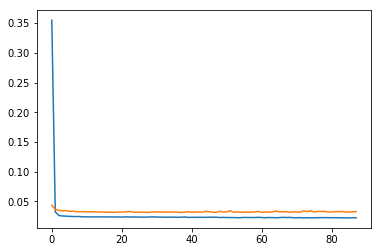

In [289]:
plot_loss(cnn_lstm_history, 'cnn_lstm_loss')

The mse test loss is:  0.0323833463092645
The mae test loss is:  0.12981718834629632


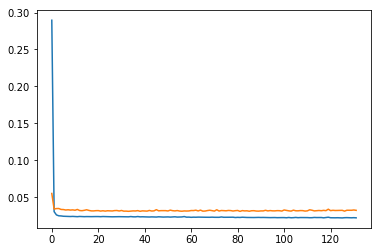

In [284]:
print('The mse test loss is: ', cnn_lstm_score[0])
print('The mae test loss is: ', cnn_lstm_score[1])
plot_loss(cnn_lstm_history, 'cnn_lstm_loss')

**Predictions**

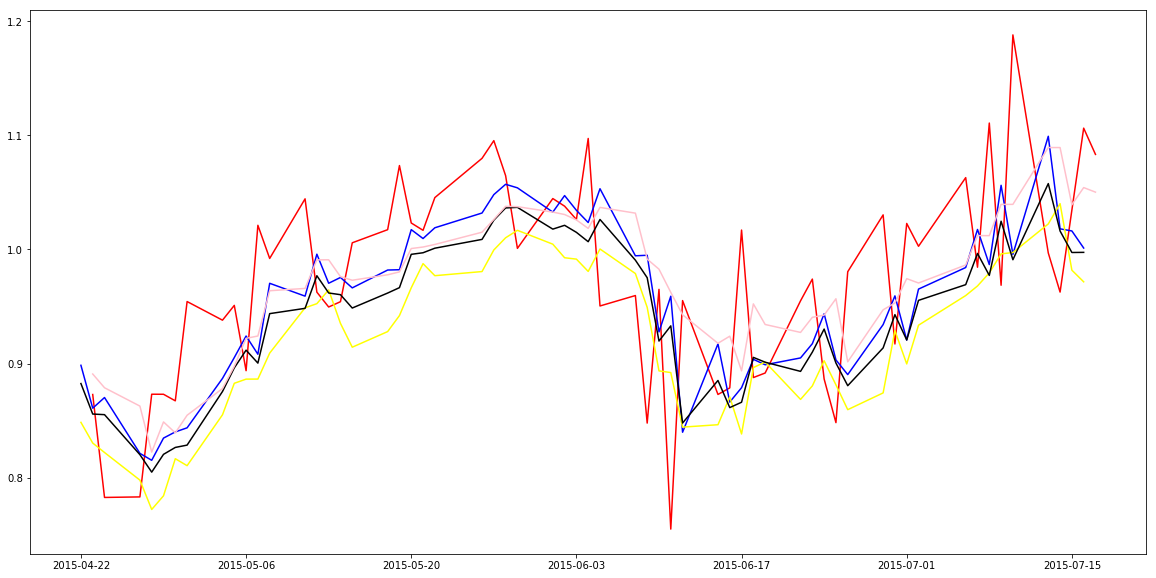

In [244]:
# Rerun y_test!

plt.close()
plt.figure(figsize=(20,10))
plt.plot(y_series_val[:60], color='red')
plt.plot(mlp_predictions[:60], color='blue')
plt.plot(cnn_predictions[:60], color='yellow')
plt.plot(rnn_predictions[:60], color='black')
plt.plot(cnn_lstm_predictions[:60], color='pink')
plt.show()

## Encoder-Decoder LSTM Multi-step Forecasting

In [55]:
from keras.layers import RepeatVector

def apply_LSTM_multistep(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1].reshape((validation_data[1].shape[0], validation_data[1].shape[1], 1))

    # define model
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation='relu', input_shape=(n_in, 1)))
    model.add(RepeatVector(2))
    model.add(LSTM(hidden_nodes, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer=optimizer, loss=loss_fct)
    model.summary()

    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val))
    score = model.evaluate(X_val, y_val, verbose=1)
    predictions = model.predict(X_val)
    
    return history, score, predictions


In [56]:
# parameters
n_in = 5
n_out = 2
epochs = 200
hidden_nodes = 20
loss_fct = 'mse'
optimizer = 'Adam'

In [97]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, n_out)

# define dataset
X_series = forecasting_data.drop(columns=['var1(t)','var1(t+1)'])
y_series = forecasting_data['var1(t)', 'var1(t+1)']
X = np.asarray(forecasting_data.drop(columns=['var1(t)','var1(t+1)']).values)
y = np.asarray(forecasting_data[['var1(t)', 'var1(t+1)']].values)

# split
X_series_train = X_series[:int(0.66*len(X))]
X_series_val= X_series[int(0.66*len(X)):]
y_series_train = y_series[:int(0.66*len(X))]
y_series_val = y_series[int(0.66*len(X)):]

X_train = X[:int(0.66*len(X))]
X_val = X[int(0.66*len(X)):]
y_train = y[:int(0.66*len(y))]
y_val = y[int(0.66*len(y)):]

In [58]:
lstm_multistep_history, lstm_multistep_score, lstm_multistep_predictions = \
    apply_LSTM_multistep(X_train, y_train, (X_val, y_val), n_in, hidden_nodes, epochs, optimizer, loss_fct)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20)                1760      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 20)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 20)             3280      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 2, 1)              21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
683/683 [==============================] - 0s 69us/step


The test loss is:  0.028962554742812587


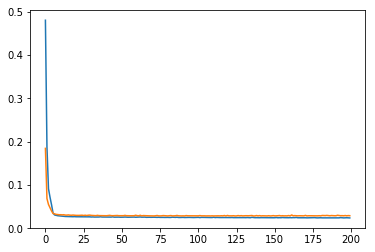

In [59]:
print('The test loss is: ', lstm_multistep_score)
plot_loss(lstm_multistep_history, 'lstm_multistep_loss')

**Studying which variable is more meaningful when predicting the pnl**

From the table below, we can see that the spread change is way more indicative of the pnl (corr = 1), because everytime the spread changes the pnl changes the same way. On the other hand, returns simply by itself do not predict the pnl, because the value of X and Y still influence the outcome.

In [301]:
pairs[5]
pairs[5][2]
df = pd.DataFrame(data={'X_test':pairs[0][2]['X_test'], 'Y_test':pairs[0][2]['Y_test']})
# alternative 1
x_returns = -(pairs[0][2]['coint_coef'])*(df.X_test-df.X_test.shift(1))/df.X_test.shift(1)
y_returns = (df.Y_test-df.Y_test.shift(1))/df.Y_test.shift(1)
dunis_returns = x_returns + y_returns
df['dunis_returns/pnl']=dunis_returns
# alternative 2
spread = df.Y_test-(pairs[0][2]['coint_coef'])*df.X_test
spread_pct_change = (spread-spread.shift(1))/abs(spread.shift(1))
df['spread_pct_change'] = spread_pct_change
df['spread']=spread
# with normalized data
normalized_spread = (spread - spread.mean())/np.std(spread)
normalized_spread_pct_change = normalized_spread.pct_change()
#df['normalized_spread']=normalized_spread
df['normalized_spread_pct_change']=normalized_spread_pct_change
# other
df['pnl'] = df.X_test.shift(periods=1)*x_returns + df.Y_test.shift(periods=1)*y_returns
# regular returns
df['ret'] = df.pnl/(np.abs(df.X_test.shift(periods=1)*(pairs[0][2]['coint_coef']))+np.abs(df.Y_test.shift(periods=1)))
df

,X_test,Y_test,dunis_returns/pnl,spread_pct_change,spread,normalized_spread_pct_change,pnl,ret
2018-01-02,10.024570,21.0400,NaN,NaN,7.973652,NaN,NaN,NaN
2018-01-03,10.240998,21.3200,-0.014833,-0.000263,7.971552,0.003465,-0.002100,-0.000062
2018-01-04,10.260674,21.3900,0.000779,0.005564,8.015907,-0.072951,0.044355,0.001279
2018-01-05,10.211485,21.3800,0.005781,0.006751,8.070020,-0.096005,0.054114,0.001557
2018-01-08,10.270511,21.4900,-0.002389,0.004097,8.103084,-0.064889,0.033064,0.000953
2018-01-09,10.447589,21.7500,-0.010374,0.003602,8.132275,-0.061265,0.029191,0.000837
2018-01-10,10.516453,21.8700,-0.003074,0.003719,8.162516,-0.067610,0.030241,0.000855
2018-01-11,10.536128,21.9500,0.001219,0.006659,8.216871,-0.130333,0.054355,0.001528
2018-01-12,10.683693,22.1400,-0.009599,-0.000285,8.214530,0.006454,-0.002341,-0.000066
2018-01-16,10.595154,22.0300,0.005834,0.000658,8.219934,-0.014805,0.005404,0.000150


In [302]:
df.pnl.corr(df.spread_pct_change)

0.9946504653335959

In [303]:
df.spread_pct_change.corr(df.ret)

0.9997079157457316

In [259]:
df.normalized_spread_pct_change.corr(df.ret)

0.0388750160893099

It thus make totally sense to predict the spread percentage change, assuming we buy the stock at its current price. However, if we consider we always put 1$ on each side of the trade, the scenario shifts.

In [309]:
pairs[5]
pairs[5][2]
df = pd.DataFrame(data={'X_test':pairs[0][2]['X_train'][train_val_split:],
                        'Y_test':pairs[0][2]['Y_train'][train_val_split:]})
# alternative 1
x_returns = -(pairs[0][2]['coint_coef'])*(df.X_test-df.X_test.shift(1))/df.X_test.shift(1)
y_returns = (df.Y_test-df.Y_test.shift(1))/df.Y_test.shift(1)
dunis_returns = x_returns + y_returns
df['dunis_returns/pnl']=dunis_returns
# alternative 2
spread = df.Y_test-(pairs[0][2]['coint_coef'])*df.X_test
spread_pct_change = (spread-spread.shift(1))/abs(spread.shift(1))
df['spread_pct_change'] = spread_pct_change
df['spread']=spread
# with normalized data
normalized_spread = (spread - spread.mean())/np.std(spread)
normalized_spread_pct_change = normalized_spread.pct_change()
#df['normalized_spread']=normalized_spread
df['normalized_spread_pct_change']=normalized_spread_pct_change
# other
df['pnl'] = df.X_test.shift(periods=1)*x_returns + df.Y_test.shift(periods=1)*y_returns
# regular returns
df['ret'] = df.pnl/(np.abs(df.X_test.shift(periods=1)*(pairs[0][2]['coint_coef']))+np.abs(df.Y_test.shift(periods=1)))
df

,X_test,Y_test,dunis_returns/pnl,spread_pct_change,spread,normalized_spread_pct_change,pnl,ret
2015-04-15,14.372813,26.7300,NaN,NaN,7.996011,NaN,NaN,NaN
2015-04-16,14.549891,27.0800,-0.002965,0.014906,8.115202,0.109258,0.119191,0.002622
2015-04-17,14.490865,26.9300,-0.000251,-0.009003,8.042139,-0.060378,-0.073064,-0.001587
2015-04-20,14.589242,27.1100,-0.002165,0.006438,8.093912,0.045533,0.051773,0.001130
2015-04-21,14.412164,26.7500,0.002541,-0.015962,7.964720,-0.108672,-0.129191,-0.002801
2015-04-22,14.500703,26.8000,-0.006138,-0.008212,7.899316,-0.061724,-0.065404,-0.001436
2015-04-23,14.687618,27.2800,0.001109,0.029923,8.135684,0.237743,0.236368,0.005172
2015-04-24,14.736806,27.3100,-0.003265,-0.004193,8.101571,-0.027721,-0.034114,-0.000735
2015-04-27,14.648268,27.1300,0.001240,-0.007973,8.036975,-0.053988,-0.064596,-0.001389
2015-04-28,14.638430,27.0700,-0.001336,-0.005870,7.989798,-0.041680,-0.047177,-0.001021


In [310]:
df.spread_pct_change.corr(df.ret)

0.989613730214564